# CloudSat in Python
### 課程開始前請各位同學執行：conda install -c conda-forge pyhdf
在這裡，我們會試著基於Python來處理CloudSat，另外有matlab code一樣可以處理CloudSat資料

以下會以2B-GEOPROF.hdf來當作示範的處理目標


In [1]:
from pyhdf.SD  import SD, SDC
from pyhdf.V import *
from pyhdf.HDF import *
import matplotlib.pyplot as plt
import os
os.environ['PROJ_LIB'] = 'D:\\program\\anaconda3\\Library\\share\\'
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import pprint
import gc 

#####Fuction for extracting variable names from hdf file
def HDFvars(File):
    hdfFile = SD(File, SDC.READ)
    dsets = hdfFile.datasets()
    k = []
    for key in dsets.keys():
        k.append(key)
    k.sort()
    hdfFile.end() # close the file
    return k
#####Function end 

In [2]:
###MODIS.hdf資料讀取＃額外補充#不用實際操作
FILE_NAME ='MYD06_L2.A2009219.0525.061.2018045212424.hdf'
hdf = SD(FILE_NAME, SDC.READ)

# Read geolocation dataset.
lat = hdf.select('Latitude')
latitude_modis_north = lat[:,:]
lon = hdf.select('Longitude')
longitude_modis_north = lon[:,:]

# Read dataset.
top_temp = hdf.select('Cloud_Top_Temperature')
#pprint.pprint(top_temp.attributes())
for key, value in top_temp.attributes().items():
    print(key, value)
    if key == 'add_offset':
        add_offset = value  
    if key == 'scale_factor':
        scale_factor = value

top_temp_modis_north = (top_temp[:,:]-add_offset)*scale_factor
hdf.end() 
###

FILE_NAME = 'MYD06_L2.A2009219.0520.061.2018045212711.hdf'
hdf = SD(FILE_NAME, SDC.READ)

# Read geolocation dataset.
lat = hdf.select('Latitude')
latitude_modis_south = lat[:,:]
lon = hdf.select('Longitude')
longitude_modis_south = lon[:,:]

# Read dataset.
top_temp = hdf.select('Cloud_Top_Temperature')

top_temp_modis_south = (top_temp[:,:]-add_offset)*scale_factor
hdf.end() 
###

valid_range [0, 20000]
_FillValue -32768
long_name Temperature from Ancillary Data at Retrieved Cloud Top Pressure Level
units K
scale_factor 0.009999999776482582
add_offset -15000.0
Parameter_Type Output
Cell_Along_Swath_Sampling [3, 2028, 5]
Cell_Across_Swath_Sampling [3, 1348, 5]
Geolocation_Pointer Internal geolocation arrays


##1. CloudSat.hdf資料讀取

通常NASA提供的hdf檔變數大部分都被儲存在Scientific Data Sets(SDS)中

可以利用pyhdf.SD library 就把資料取出(就像前面的MODIS.hdf一樣)

但是CloudSat 的hdf 資料被分開儲存SDS 中只存了幾個變數

這些變數他們的geolocation data被存在Vdata中

這時候我們需要pyhdf.V來幫助我們讀取Vdata

###a. 資料讀取-Vdata

In [3]:
filename = '2009219043145_17429_CS_2B-GEOPROF_GRANULE_P_R04_E02.hdf'
#讀取vdata
reading_vdata = HDF(filename, HC.READ).vstart()
vdata =reading_vdata.vdatainfo()

pprint.pprint(vdata[1:10])##把vdata存的變數名稱輸出
members = [ 8 , 10, 11, 18 ,28 ,35] ##我們想提出的geolocation data
nrecs = []
names = []
for ref in members:
 #       # Vdata tag
    vd = reading_vdata.attach(ref)
    nrecs.append(vd.inquire()[0])  ## number of records of the Vdata
    names.append(vd.inquire()[-1]) ## name of the Vdata
    vd.detach()

print(names)##輸出的變數名稱
print(nrecs)##變數矩陣的長度

# Read geolocation dataset.
#['UTC_start', 'Latitude', 'Longitude', 'Data_quality', 'MODIS_Cloud_Fraction','Navigation_land_sea_flag']
idx = names.index('UTC_start')
var = reading_vdata.attach(members[idx])
UTC_time = var.read(nrecs[idx])

idx = names.index('Latitude')
var = reading_vdata.attach(members[idx])
latitude = var.read(nrecs[idx])

idx = names.index('Longitude',)
var = reading_vdata.attach(members[idx])
longitude = var.read(nrecs[idx])

idx = names.index('MODIS_Cloud_Fraction',)
var = reading_vdata.attach(members[idx])
MODIS_cloud_fraction = var.read(nrecs[idx])

idx = names.index('Data_quality',)
var = reading_vdata.attach(members[idx])
data_quality = var.read(nrecs[idx])

del reading_vdata
gc.collect()

[('UTC_start', '', 8, 1, 1, 5, 4, 1962, 0),
 ('TAI_start', '', 9, 1, 1, 5, 8, 1962, 0),
 ('Latitude', '', 10, 37080, 1, 5, 4, 1962, 0),
 ('Longitude', '', 11, 37080, 1, 5, 4, 1962, 0),
 ('Range_to_intercept', '', 13, 37080, 1, 5, 4, 1962, 0),
 ('DEM_elevation', '', 14, 37080, 1, 7, 2, 1962, 0),
 ('Vertical_binsize', '', 15, 1, 1, 5, 4, 1962, 0),
 ('Pitch_offset', '', 16, 1, 1, 5, 4, 1962, 0),
 ('Roll_offset', '', 17, 1, 1, 5, 4, 1962, 0)]
['UTC_start', 'Latitude', 'Longitude', 'Data_quality', 'MODIS_Cloud_Fraction', 'Navigation_land_sea_flag']
[1, 37080, 37080, 37080, 37080, 37080]


0

In [4]:
lat_demo = pd.DataFrame(latitude[:], columns= ['緯度'])
print(lat_demo.shape)
lat_demo.head()

(37080, 1)


,緯度
0,-0.008769
1,-0.018439
2,-0.028110
3,-0.037780
4,-0.047450


In [5]:
lon_demo = pd.DataFrame(longitude[:], columns= ['經度'])
print(lon_demo.shape)
lon_demo.head()

(37080, 1)


,經度
0,-40.985600
1,-40.987648
2,-40.989697
3,-40.991749
4,-40.993797


###b. 資料讀取-SDS

In [6]:
HDFvars(filename)

['CPR_Cloud_mask', 'Gaseous_Attenuation', 'Height', 'Radar_Reflectivity']

In [7]:
# Read dataset.
hdfFile = SD(filename, SDC.READ)##SDS資料輸出
Reflectivity = hdfFile.select('Radar_Reflectivity')##輸出變數
Cloud_mask = hdfFile.select('CPR_Cloud_mask')
Height = hdfFile.select('Height')
pprint.pprint(Reflectivity.attributes())##輸出變數的基本資料

{'_FillValue': 15360,
 'factor': 100.0,
 'long_name': 'Radar Reflectivity Factor',
 'missing': -8888,
 'missop': '==',
 'offset': 0.0,
 'units': 'dBZe',
 'valid_range': [-4000, 5000]}


通常SDS資料輸出後也要輸出它的attribute稍微了解一下這個變數的基本性質

有時候資料輸出後矩陣裡的值還要經過處理後我們才能拿來使用

這時候就要用到factor & offset 來做轉換

###通常轉換式是長這樣: (Data_value - offset)*factor
 

In [8]:
demo_longitude=np.asarray(longitude)
demo_latitude=np.asarray(latitude)
demo_Reflectivity=np.asarray(Reflectivity[:,:])
demo_Height=np.asarray(Height[:,:])
print(demo_Reflectivity.shape)
print(demo_Height.shape)
Ref_array_demo = pd.DataFrame(Reflectivity[:,:] ,columns=demo_Height[0,:] ,index=demo_latitude[:,0])
Ref_array_demo.head()

(37080, 125)
(37080, 125)


,24861,24621,24381,24141,23901,23662,23422,23182,22942,22702,...,-2720,-2959,-3199,-3439,-3679,-3919,-4159,-4398,-4638,-4878
-0.008769,-8888,-3230,-8888,-8888,-8888,-8888,-8888,-8888,-8888,-3840,...,16737,16737,16737,16738,16738,16738,16739,16739,16739,16740
-0.018439,-3439,-8888,-5446,-2922,-2881,-4144,-8888,-2882,-2756,-8888,...,16737,16737,16737,16738,16738,16738,16739,16739,16739,16740
-0.028110,-8888,-2779,-3535,-3598,-2775,-8888,-3316,-8888,-8888,-3416,...,16737,16737,16737,16738,16738,16738,16739,16739,16739,16740
-0.037780,-3278,-3255,-3319,-3331,-8888,-8888,-3021,-2751,-8888,-8888,...,16737,16737,16737,16738,16738,16738,16739,16739,16739,16740
-0.047450,-3025,-3356,-8888,-8888,-8888,-3892,-2990,-3254,-3951,-4453,...,16737,16737,16737,16738,16738,16738,16739,16739,16739,16740


In [9]:
#利用經緯度矩陣的值找出台灣附近在矩陣中的位置
mo_longitude=np.asarray(longitude)
mo_latitude=np.asarray(latitude)
shape1 = mo_longitude.shape
lonlat_mask= np.zeros((shape1[0],1),dtype=int)

for i in range(0,shape1[0]):
    if mo_longitude[i] >115  and  mo_longitude[i]<125  and  mo_latitude[i] > 15  and  mo_latitude[i] < 30:
        lonlat_mask[i]= 1##有在所選經緯度涵蓋範圍的矩陣會被設成'1'
        
taiwan_array_size=sum(lonlat_mask)
print("Array length over Taiwan area:")
print(sum(taiwan_array_size))


Array length over Taiwan area:
1556


In [10]:
#從完整變數矩陣中取出台灣附近的矩陣
taiwan_Reflectivity= np.zeros((taiwan_array_size[0],125))
taiwan_Cloud_mask= np.zeros((taiwan_array_size[0],125))
taiwan_height= np.zeros((taiwan_array_size[0],125))

taiwan_lat= np.zeros((taiwan_array_size[0],1))
taiwan_lon= np.zeros((taiwan_array_size[0],1))
k=0
for i in range(0,shape1[0]):
    if lonlat_mask[i]>0:
        taiwan_Reflectivity[k,:]= Reflectivity[i,:]/100
        taiwan_Cloud_mask[k,:]= Cloud_mask[i,:]
        taiwan_height[k,:]=Height[i,:]
        taiwan_lat[k,0]=mo_latitude[i]
        taiwan_lon[k,0]=mo_longitude[i]
        k=k+1


In [11]:
Ref_array_demo = pd.DataFrame(taiwan_Reflectivity[:,:] ,columns=taiwan_height[0,:] ,index=taiwan_lat[:,0])
Ref_array_demo.head()

,25000.0,24760.0,24520.0,24281.0,24041.0,23801.0,23561.0,23321.0,23081.0,22842.0,...,-2580.0,-2820.0,-3060.0,-3300.0,-3540.0,-3779.0,-4019.0,-4259.0,-4499.0,-4739.0
15.002561,-88.88,-88.88,-30.94,-37.99,-31.21,-32.75,-88.88,-88.88,-88.88,-88.88,...,167.36,167.36,167.36,167.37,167.37,167.37,167.37,167.38,167.38,167.38
15.012221,-88.88,-30.28,-28.35,-31.04,-88.88,-33.54,-30.27,-38.25,-31.50,-28.77,...,167.36,167.36,167.36,167.37,167.37,167.37,167.37,167.38,167.38,167.38
15.021882,-88.88,-29.49,-31.71,-88.88,-40.81,-88.88,-88.88,-88.88,-88.88,-31.88,...,167.36,167.36,167.36,167.37,167.37,167.37,167.37,167.38,167.38,167.38
15.031543,-28.58,-88.88,-88.88,-88.88,-88.88,-88.88,-88.88,-88.88,-88.88,-29.45,...,167.36,167.36,167.36,167.37,167.37,167.37,167.37,167.38,167.38,167.38
15.041203,-88.88,-88.88,-88.88,-88.88,-88.88,-88.88,-40.25,-32.06,-35.96,-88.88,...,167.36,167.36,167.36,167.37,167.37,167.37,167.37,167.38,167.38,167.38


##2. CloudSat資料視覺化

In [17]:
#先轉置矩陣再把columns倒過來，為了畫圖
Ref= taiwan_Reflectivity[:,:].T
r_Ref = Ref[::-1]
c_mask=taiwan_Cloud_mask[:,:].T
r_c_mask = c_mask[::-1]
Hef= taiwan_height[:,:].T
r_Hef = Hef[::-1]
ref_height=np.mean(r_Hef,axis=1)
ref_height=np.around(ref_height)
taiwan_lat = np.around(taiwan_lat,decimals=1)

In [13]:
#以台灣為中心畫圖，所以要調整一下經度的表示方式
mo_longitude=np.asarray(longitude)
shape1 = mo_longitude.shape

for i in range(0,shape1[0]):
    if mo_longitude[i] < -60:
        mo_longitude[i]=mo_longitude[i]+360


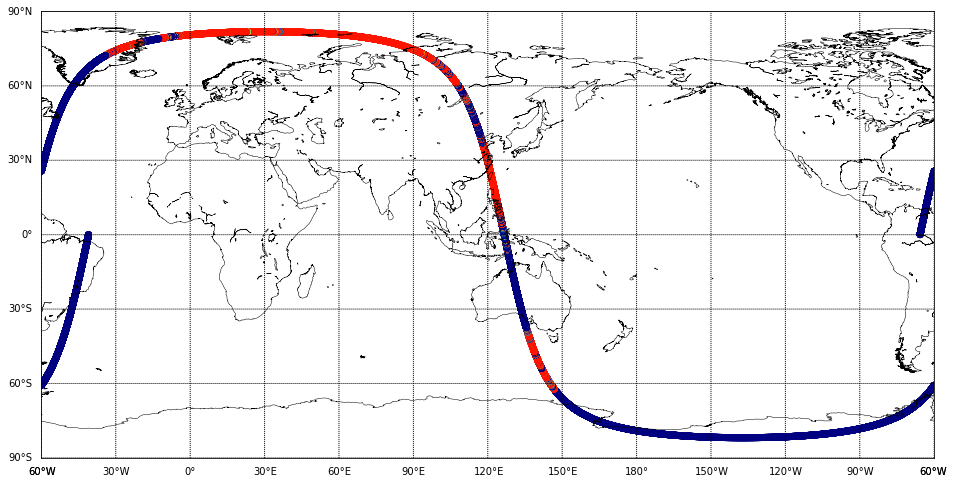

In [14]:
fig = plt.figure(figsize=(16,12)) 
m = Basemap(llcrnrlon=-60, urcrnrlon=300., llcrnrlat=-90., urcrnrlat=90.,resolution='l')
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 30.), labels=[0, 0, 0, 1])
m.scatter(mo_longitude[:], latitude[:] , c=MODIS_cloud_fraction[:] ,cmap=plt.cm.get_cmap('jet',10), vmin=10, vmax=120)

如果我們把2009/8/7號當天所有CloudSat所觀測過的軌道畫出來

會如下圖所示:

<img src='img/demo_track.png'  />

先看看

2009/08/07當天台灣的MODIS衛星雲圖:

<img src='img/20090807.png'  />

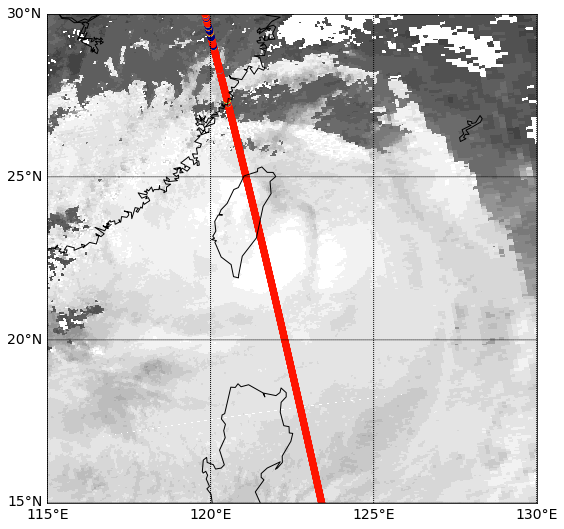

In [15]:
fig = plt.figure(figsize=(9,9)) 
m = Basemap(llcrnrlon=115, urcrnrlon=130., llcrnrlat=15., urcrnrlat=30.,resolution='l')
m.drawcoastlines(linewidth=1)
m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0], fontsize=14)
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0, 0, 0, 1], fontsize=14)

#MODIS Cloud Top Temperature plot
x, y = m(longitude_modis_north, latitude_modis_north)
m.pcolormesh(x, y, top_temp_modis_north,cmap=plt.cm.get_cmap('gray_r',20), vmin=190, vmax=350)
x, y = m(longitude_modis_south, latitude_modis_south)
m.pcolormesh(x, y, top_temp_modis_south,cmap=plt.cm.get_cmap('gray_r',20), vmin=190, vmax=350)

# Track plot
m.scatter(mo_longitude[:], latitude[:] , c=MODIS_cloud_fraction[:] ,cmap=plt.cm.get_cmap('jet',10), vmin=10, vmax=120)


Text(0.5, 0, 'Latitude')

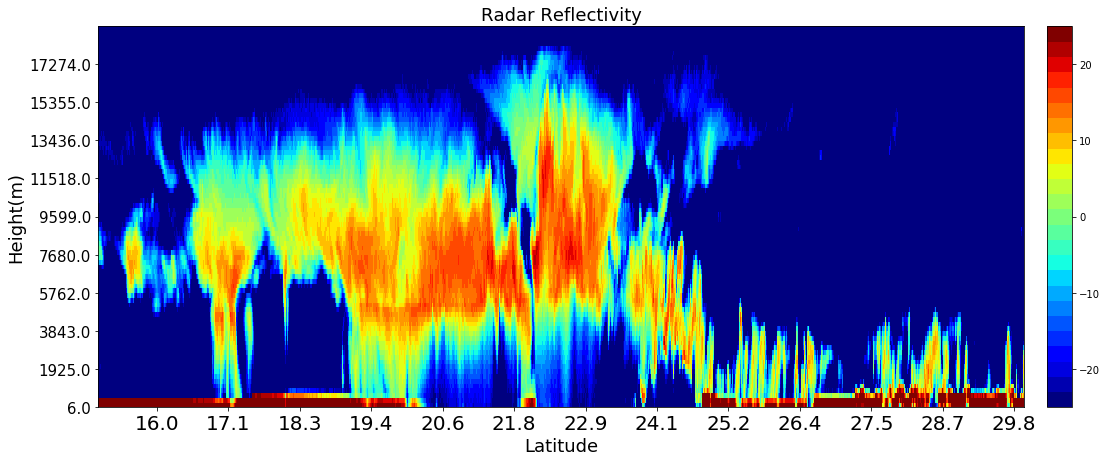

In [16]:
#雷達回波 plot
fig = plt.figure(figsize=(20,7)) 
plt.pcolormesh(r_Ref[20:100,:],cmap=plt.cm.get_cmap('jet',25), vmin=-25, vmax=25)
plt.colorbar(aspect=15, pad=0.02)
plt.title('Radar Reflectivity',fontsize=18)
#XY軸設定指令
plt.yticks(np.arange(0,80,step=8), (ref_height[20:100:8,]))
plt.xticks(np.arange(99,1556,step=120), (taiwan_lat[99:1556:120,0]))
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=15)
plt.ylabel('Height(m)',color='k',fontsize=18)
plt.xlabel('Latitude',color='k',fontsize=18)

Text(0.5, 0, 'Latitude')

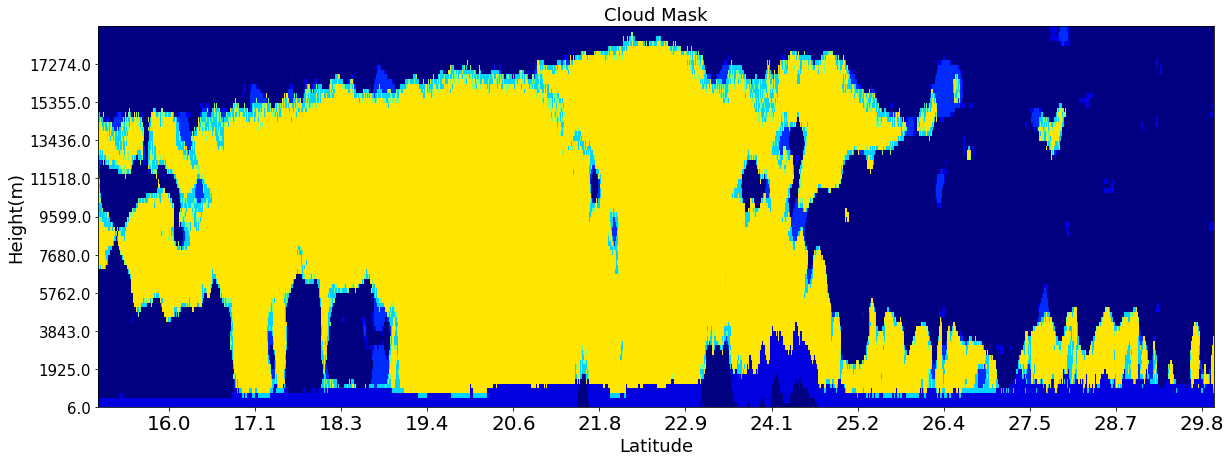

In [45]:
#Cloud mask plot
fig = plt.figure(figsize=(20,7)) 
plt.pcolormesh(r_c_mask[20:100,:],cmap=plt.cm.get_cmap('jet',25), vmin=0, vmax=60)
plt.title('Cloud Mask',fontsize=18)
#XY軸設定指令
plt.yticks(np.arange(0,80,step=8), (ref_height[20:100:8,]))
plt.xticks(np.arange(99,1556,step=120), (taiwan_lat[99:1556:120,0]))
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=15)
plt.ylabel('Height(m)',color='k',fontsize=18)
plt.xlabel('Latitude',color='k',fontsize=18)

Text(0.5, 0, 'Latitude')

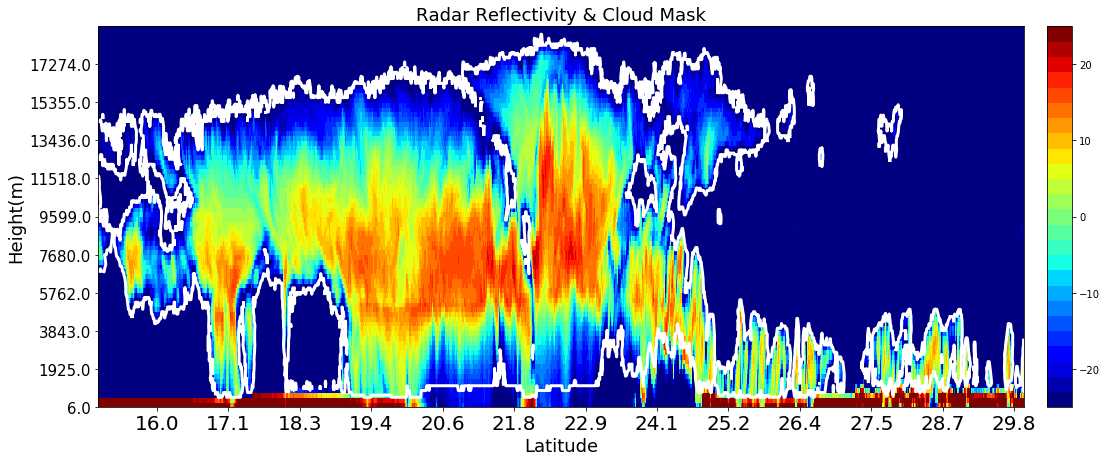

In [53]:
#雷達回波 & Cloud mask plot
fig = plt.figure(figsize=(20,7)) 
plt.pcolormesh(r_Ref[20:100,:],cmap=plt.cm.get_cmap('jet',25), vmin=-25, vmax=25)
plt.colorbar(aspect=15, pad=0.02)
levels = np.arange(20,60,20)
plt.contour(r_c_mask[20:100,:],levels,linewidths=3,colors='w')
plt.title('Radar Reflectivity & Cloud Mask',fontsize=18)
#XY軸設定指令
plt.yticks(np.arange(0,80,step=8), (ref_height[20:100:8,]))
plt.xticks(np.arange(99,1556,step=120), (taiwan_lat[99:1556:120,0]))
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=15)
plt.ylabel('Height(m)',color='k',fontsize=18)
plt.xlabel('Latitude',color='k',fontsize=18)

#Reference

Chien, F.-C., and H.-C. Kuo, 2011: On the extreme rainfall of Typhoon Morakot (2009). J. Geophys. Res., 116, D05104, doi:10.1029/2010JD015092. 
        
http://www.cloudsat.cira.colostate.edu/

##hdf reading and info

http://hdfeos.org/index.php

https://hdfeos.org/software/pyhdf.php



In [ ]:
demo_file = os.listdir('C:\\Users\\linnick\\Desktop\\cloudsat_python\\demo_track\\')
#print(demo_file)
srcdir  = 'C:\\Users\\linnick\\Desktop\\cloudsat_python\\demo_track\\'
demo_lon= np.zeros((37080,14))
demo_lat= np.zeros((37080,14))
demo_cloud_fraction= np.zeros((37080,14))
for i in range(0,14):
    filename_demo = [srcdir+demo_file[i]]
    #print(filename_demo)
    reading_vdata = HDF(filename_demo[0], HC.READ).vstart()
    vdata =reading_vdata.vdatainfo()
    #pprint.pprint(vdata[1:10])
    members = [ 8 , 10, 11, 18 ,28 ,35] #資料的基本性質
    nrecs = []
    names = []
    for ref in members:
 #       # Vdata tag
        vd = reading_vdata.attach(ref)
        nrecs.append(vd.inquire()[0])  # number of records of the Vdata
        names.append(vd.inquire()[-1]) # name of the Vdata
        vd.detach()

#print(names)
#print(nrecs)

#['UTC_start', 'Latitude', 'Longitude', 'Data_quality', 'MODIS_Cloud_Fraction','Navigation_land_sea_flag']

    idx = names.index('Latitude')
    var = reading_vdata.attach(members[idx])
    latitude_demo = var.read(nrecs[idx])

    latitude_demo=np.asarray(latitude_demo)
    demo_lat[:,i] = latitude_demo[0:37080,0]

    
    idx = names.index('Longitude',)
    var = reading_vdata.attach(members[idx])
    longitude_demo = var.read(nrecs[idx])
    longitude_demo=np.asarray(longitude_demo)
    demo_lon[:,i]=longitude_demo[0:37080,0]
    
    idx = names.index('MODIS_Cloud_Fraction',)
    var = reading_vdata.attach(members[idx])
    MODIS_cloud_fraction_demo = var.read(nrecs[idx])
    MODIS_cloud_fraction_demo =np.asarray(MODIS_cloud_fraction_demo )
    demo_cloud_fraction[:,i]=MODIS_cloud_fraction_demo[0:37080,0]
    del reading_vdata
    gc.collect()

In [37]:
shape1 = demo_lon.shape
print(shape1)

for i in range(0,37080):
    for j in range(0,14):
        if demo_lon[i,j] < -60:
            demo_lon[i,j]=demo_lon[i,j]+360
fig = plt.figure(figsize=(16,12)) 
m = Basemap(llcrnrlon=-60, urcrnrlon=300., llcrnrlat=-90., urcrnrlat=90.,resolution='l')
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 30.), labels=[0, 0, 0, 1])
for i in range(0,14):
    m.scatter(demo_lon[:,i], demo_lat[:,i] , c=demo_cloud_fraction[:,i] ,cmap=plt.cm.get_cmap('jet',10), vmin=10, vmax=120)
fig.savefig('demo_track.png', dpi=250)

(37080, 14)
